In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import re
import seaborn
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize, MaxAbsScaler
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  BayesianRidge, ElasticNet, Ridge)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

%matplotlib inline
%load_ext autoreload
%autoreload 2
%autosave 180

from data_mining import *

Autosaving every 180 seconds


In [2]:
residues_normalizer = Normalizer()
hbonds_normalizer = MaxAbsScaler()
solvation_normalizer = MaxAbsScaler()
backboneatom_normalizer = Normalizer()

CASP = [
    ('*residues-d4-b10-a12-c5-n0--skip_errors.mat',
     '8269eab4b9ebaa69aa1467308c48ed4f',
     lambda X: residues_normalizer.fit_transform(X),
     lambda X: residues_normalizer.transform(X)),
    ('*hbonds-b6-a6-c6-n2--skip_errors.mat',
     '8269eab4b9ebaa69aa1467308c48ed4f',
     lambda X: hbonds_normalizer.fit_transform(X),
     lambda X: hbonds_normalizer.transform(X)),
    ('*solvation-b3-a2-c15--skip_errors.mat',
     '8269eab4b9ebaa69aa1467308c48ed4f',
     lambda X: solvation_normalizer.fit_transform(X),
     lambda X: solvation_normalizer.transform(X)),
    ('*backboneatom-b25-c7-n0--residue_type_dependent--skip_errors.mat',
     'd3efaf4824785305b93d775d0e3b0a46',
     lambda X: backboneatom_normalizer.fit_transform(X),
     lambda X: backboneatom_normalizer.transform(X)),
]

In [3]:
%%time

X, scores = get_dataset(
    [(pattern, checksum, fit_transform)
         for (pattern, checksum, fit_transform, transform) in CASP],
    '^.*CASP([5-9]|10)/T..../.*$'
)

Shape of the first dataset:  (160586, 4371840)
Shape of the second dataset: (160586, 216)
Shape of the final dataset:  (160586, 4372056)
Shape of the first dataset:  (160586, 4372056)
Shape of the second dataset: (160586, 138)
Shape of the final dataset:  (160586, 4372194)
Shape of the first dataset:  (160586, 4372194)
Shape of the second dataset: (160579, 239775)
Shape of the final dataset:  (160579, 4611969)
CPU times: user 9min 15s, sys: 49.9 s, total: 10min 5s
Wall time: 10min 5s


In [4]:
print(X.shape)
X.size

(160579, 4611969)


1906525206

In [5]:
def simplify(col_name):
    col_name = re.sub('^model__', '', re.sub('^param_', '', col_name))
    return re.sub('_', '', col_name)

# Ridge Regression

In [6]:
class IndexOneHotImputer(OneHotImputer):
    def fit_transform(self, X, y, *args, **kwargs):
        return super(IndexOneHotImputer, self).fit_transform(X, scores.iloc[y], *args, **kwargs)

class IndexRRModel(RRModel):
    def fit(self, X, y, **fit_params):
        super(IndexRRModel, self).fit(X, scores.iloc[y], **fit_params)
        return self

def scoring_corr(scorer, X, y):
    return -scoring_results(
        X, scores.iloc[y], lambda X: scorer.predict(X), num_plots=0
    )[0]['GDT-TS-score'][['Mean Pearson', 'Mean Spearman', 'Mean Kendall tau']].mean()

## Correlation

In [12]:
parameters = {'model__alpha': (0.1, 1, 5),
              'imputer__weight': (10, 100, 200)}


rr_model_corr = GridSearchCV(
    Pipeline([('imputer', IndexOneHotImputer()),
              ('model', IndexRRModel(normalize=False, fit_intercept=False, solver='sparse_cg'))]),
    parameters,
    n_jobs=3,
    cv=KFold(),
    scoring=scoring_corr
)

In [ ]:
%%time

rr_model_corr.fit(X, np.arange(len(scores)))

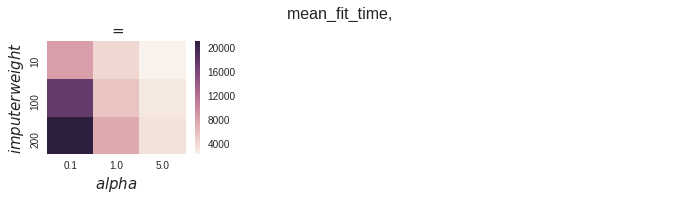

In [17]:
df = pd.DataFrame(rr_model_corr.cv_results_).sort_values(by='mean_test_score')

param_cols = [simplify(c) for c in df.columns if c.startswith('param_')]
df.columns = [simplify(c) if c.startswith('param_') else c for c in df.columns]

plot_heatmaps(df, 'mean_test_score', param_cols)
plot_heatmaps(df, 'mean_fit_time', param_cols)

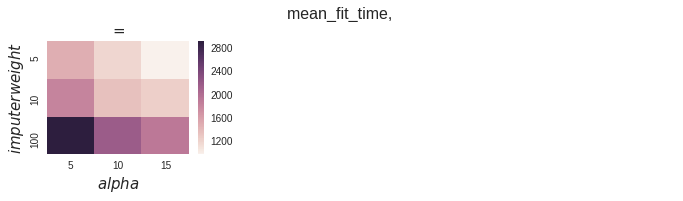

In [11]:
df = pd.DataFrame(rr_model_corr.cv_results_).sort_values(by='mean_test_score')

param_cols = [simplify(c) for c in df.columns if c.startswith('param_')]
df.columns = [simplify(c) if c.startswith('param_') else c for c in df.columns]

plot_heatmaps(df, 'mean_test_score', param_cols)
plot_heatmaps(df, 'mean_fit_time', param_cols)